In [ ]:
%%shell
pip install cython

## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation. Crowd annotations (iscrowd=1) are used to label large groups of objects (e.g. a crowd of people).

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.

One note on the labels. The model considers class 0 as background. If your dataset does not contain the background class, you should not have 0 in your labels. For example, assuming you have just two classes, cat and dog, you can define 1 (not 0) to represent cats and 2 to represent dogs. So, for instance, if one of the images has both classes, your labels tensor should look like [1,2].


### Writing a custom dataset for items

Let's write a dataset for the dataset.


In [1]:
%%shell
rm -rf dataset2

# extract it in the current folder
unzip -q dataset2.zip

In [2]:
%%shell
ls dataset2

annotations  images


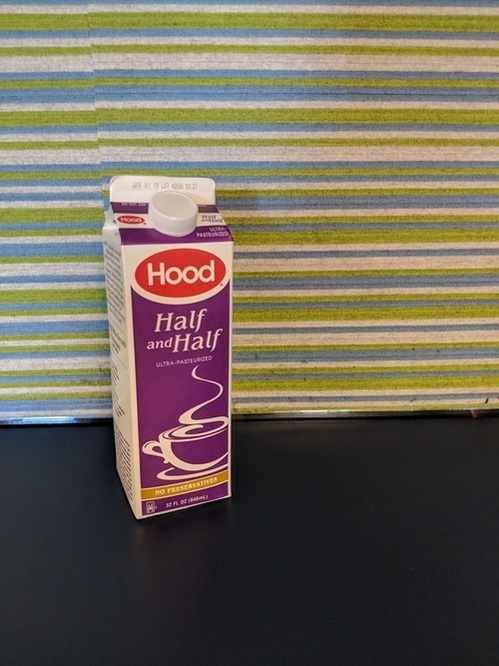

In [3]:
from PIL import Image
Image.open('/content/dataset2/images/1.jpg')

In [4]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import xml.etree.ElementTree as ET

In [5]:
name_to_label = {
    'obj1': 1,
    'obj2': 2,
    'obj3': 3,
    'obj4': 4,
}

In [6]:
root = '/content/dataset2/'

In [7]:
imgs = list(sorted(os.listdir(os.path.join(root, "images"))))

In [8]:
annotations = list(sorted(os.listdir(os.path.join(root, "annotations"))))

In [9]:
annotation_path = os.path.join(root, "annotations", annotations[1])

In [10]:
annotation_path

'/content/dataset2/annotations/10.xml'

In [11]:
img_path = os.path.join(root, "images", imgs[1])

In [12]:
img_path

'/content/dataset2/images/10.jpg'

In [13]:
tree = ET.parse(annotation_path)
root = tree.getroot()
print(root.tag)

annotation


In [14]:
boxes = []
labels = []
for obj in root.findall('object'):
    name = obj.find('name').text
    label = name_to_label.get(name)
    labels.append(label)
    bndbox = obj.find('bndbox')
    xmin = bndbox.find('xmin').text
    ymin = bndbox.find('ymin').text
    xmax = bndbox.find('xmax').text
    ymax = bndbox.find('ymax').text
    boxes.append([xmin, ymin, xmax, ymax])

In [15]:
labels

[2, 3]

In [16]:
labels = torch.tensor(labels, dtype=torch.int64)

In [17]:
boxes

[['86', '102', '216', '439'], ['150', '377', '445', '490']]

So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

In [18]:

class FourClassDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms

        # /content/dataset2/annotations
        # /content/dataset2/images
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.annotations = list(sorted(os.listdir(os.path.join(root, "annotations"))))

    def __getitem__(self, idx):
        # load images and annotation
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annotation_path = os.path.join(self.root, "annotations", self.annotations[idx])
        img = Image.open(img_path).convert("RGB")

        tree = ET.parse(annotation_path)
        root = tree.getroot()

        boxes = []
        labels = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            label = name_to_label.get(name)
            labels.append(label)
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.tensor(labels, dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = torch.zeros((len(labels),), dtype=torch.int64)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [19]:
dataset = FourClassDataset('/content/dataset2/')
dataset[2]

(<PIL.Image.Image image mode=RGB size=499x666>,
 {'boxes': tensor([[130., 271., 367., 467.]]),
  'labels': tensor([1]),
  'image_id': tensor([2]),
  'area': tensor([46452.]),
  'iscrowd': tensor([0])})

In [ ]:
# dataset = FourClassDataset('PennFudanPed/')
# dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536>,
 {'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]),
  'labels': tensor([1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([0]),
  'area': tensor([35358., 36225.]),
  'iscrowd': tensor([0, 0])})

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

## Defining your model

[Faster R-CNN](https://arxiv.org/abs/1506.01497) is a model that predicts both bounding boxes and class scores for potential objects in the image.

We will start from a model pre-trained on COCO and finetune it for our particular classes.

In [20]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_object_detection_model(num_classes):
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [21]:
%%shell
# Download TorchVision repo to use some files from references/detection
#git clone https://github.com/pytorch/vision.git
#cd vision
#git checkout v0.8.2

#cp references/detection/utils.py ../
#cp references/detection/transforms.py ../
#cp references/detection/coco_eval.py ../
#cp references/detection/engine.py ../
#cp references/detection/coco_utils.py ../

#then  replace from torch._six import string_classes with string_classes = str as suggested here: https://github.com/Lightning-Universe/lightning-bolts/issues/992
rm -rf AAIFiles.zip AAIFiles
wget https://www.dropbox.com/s/8isaehtsma2eblv/AAIFiles.zip
unzip AAIFiles.zip
mv AAIFiles/* .

--2024-06-11 17:34:35--  https://www.dropbox.com/s/8isaehtsma2eblv/AAIFiles.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /scl/fi/slb2cfbo73i0dxs278eup/AAIFiles.zip?rlkey=uhdsk7nlwa4r0xbjyfpuokx5y [following]
--2024-06-11 17:34:36--  https://www.dropbox.com/scl/fi/slb2cfbo73i0dxs278eup/AAIFiles.zip?rlkey=uhdsk7nlwa4r0xbjyfpuokx5y
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb9ce44633879725d1b6b9bfd44.dl.dropboxusercontent.com/cd/0/inline/CUpRVM34b1tprzFuveVmwTtCAKNWhYC_BaBvY0GFoeooxsc3eTKAmWwpcNhcehWJoEs9NHLO087l-huidAT3FrBExAZ_hu98sDrHTCLdbWC0Pv34261NVyjusRS5lpozUh8/file# [following]
--2024-06-11 17:34:36--  https://ucb9ce44633879725d1b6b9bfd44.dl.dropboxusercontent.com/cd/0/inline/CUpRVM34b1tprzFuveVmwTtCAKNWhYC_BaBvY0GFoe



Let's write some helper functions for data augmentation / transformation, which leverages the functions in `references/detection` that we have just copied:


In [22]:
from torch import inf
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Testing forward() method

Before iterating over the dataset, it’s good to see what the model expects during training and inference time on sample data.


In [23]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = FourClassDataset('/content/dataset2/', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions
predictions

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 189MB/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker proc

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)}]

#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [24]:
# use our dataset and defined transformations
dataset = FourClassDataset('/content/dataset2/', get_transform(train=True))
dataset_test = FourClassDataset('/content/dataset2/', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-28])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-28:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [25]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 5

# get the model using our helper function
model = get_object_detection_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by 10x every 3 epochs
lr_scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=3,gamma=0.1)

And now let's train the model for 5 epochs, evaluating at the end of every epoch.

In [26]:
from engine import train_one_epoch, evaluate
# let's train it for 5 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

#[[0, 10000000000.0], [0, 1024], [1024, 9216], [9216, 10000000000.0]]
#['all', 'small', 'medium', 'large']

#maxDets=maximum detections

Epoch: [0]  [ 0/50]  eta: 0:03:12  lr: 0.000107  loss: 1.5938 (1.5938)  loss_classifier: 1.2610 (1.2610)  loss_box_reg: 0.3230 (0.3230)  loss_objectness: 0.0084 (0.0084)  loss_rpn_box_reg: 0.0013 (0.0013)  time: 3.8404  data: 0.2746  max mem: 2134
Epoch: [0]  [10/50]  eta: 0:00:30  lr: 0.001126  loss: 1.1498 (1.1826)  loss_classifier: 0.7060 (0.7868)  loss_box_reg: 0.3594 (0.3848)  loss_objectness: 0.0051 (0.0050)  loss_rpn_box_reg: 0.0051 (0.0059)  time: 0.7744  data: 0.0353  max mem: 2292
Epoch: [0]  [20/50]  eta: 0:00:18  lr: 0.002146  loss: 0.7876 (0.9506)  loss_classifier: 0.3882 (0.5810)  loss_box_reg: 0.3174 (0.3612)  loss_objectness: 0.0010 (0.0037)  loss_rpn_box_reg: 0.0045 (0.0047)  time: 0.4666  data: 0.0104  max mem: 2292
Epoch: [0]  [30/50]  eta: 0:00:11  lr: 0.003165  loss: 0.5712 (0.7883)  loss_classifier: 0.2220 (0.4488)  loss_box_reg: 0.2879 (0.3303)  loss_objectness: 0.0011 (0.0045)  loss_rpn_box_reg: 0.0028 (0.0046)  time: 0.4667  data: 0.0099  max mem: 2292
Epoch: [

Now that training has finished, let's have a look at what it actually predicts in a test image

In [28]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `scores` as fields.

In [31]:
out_box = prediction[0]['boxes']
out_scores = prediction[0]['scores']

In [ ]:
prediction

[{'boxes': tensor([[134.6021, 172.5514, 225.4196, 409.2743],
          [178.7575, 304.9485, 465.8518, 567.7866],
          [253.4744, 126.3817, 337.8679, 358.2080],
          [252.8626, 143.3823, 339.9250, 356.5031]], device='cuda:0'),
  'labels': tensor([3, 2, 4, 2], device='cuda:0'),
  'scores': tensor([0.9939, 0.9919, 0.9782, 0.0861], device='cuda:0')}]

In [38]:
keep = torchvision.ops.nms(out_box, out_scores, 0.50)

Let's inspect the image and the predicted object detection labels.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

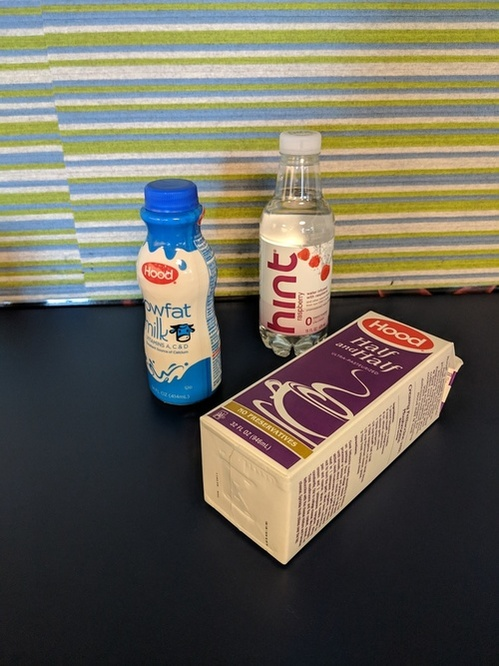

In [39]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())




**And let's now visualize the predicted object detection boxes with IOU 0.5.**




[135.14748 171.7633  224.52982 409.47043]
[182.00148 307.00214 466.38327 570.12634]
[253.90294  127.260994 338.42667  355.41455 ]


<Figure size 640x480 with 0 Axes>

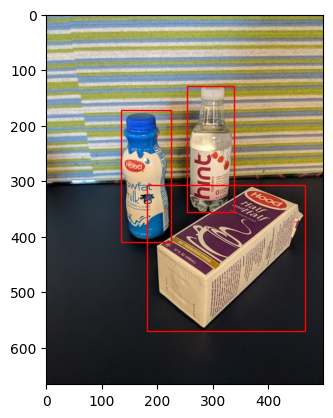

In [37]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.figure()
fig, ax = plt.subplots()
ax.imshow(img.mul(255).permute(1, 2, 0).byte().numpy())
for idx in keep:
  idx = idx.item()
  x = out_box[idx].cpu().numpy()
  print(x)
  rect = patches.Rectangle((x[0], x[1]), x[2]-x[0], x[3]-x[1], linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)

plt.show()

**And let's now visualize the predicted object detection boxes without IOU 0.5.**

[134.6021  172.55138 225.41959 409.27432]
[178.7575  304.94846 465.85184 567.78656]
[253.47441  126.381714 337.8679   358.20798 ]
[252.86264 143.38232 339.92502 356.50305]


<Figure size 640x480 with 0 Axes>

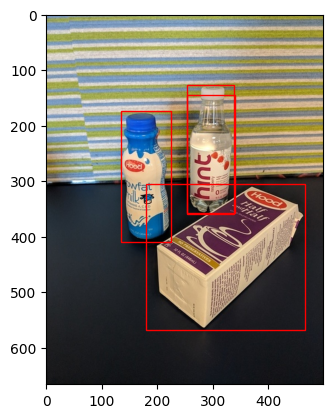

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.figure()
fig, ax = plt.subplots()
ax.imshow(img.mul(255).permute(1, 2, 0).byte().numpy())
for x in prediction[0]['boxes'].cpu().numpy():
  print(x)
  rect = patches.Rectangle((x[0], x[1]), x[2]-x[0], x[3]-x[1], linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)

plt.show()


In [ ]:
# pick one image from the test set
img, _ = dataset_test[4]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [ ]:
prediction

[{'boxes': tensor([[260.3714, 277.2363, 391.0482, 447.8389],
          [109.4897, 268.8335, 238.7567, 500.6893],
          [107.7994, 257.8612, 236.5604, 503.3305],
          [263.7885, 278.0154, 397.6712, 440.1295]], device='cuda:0'),
  'labels': tensor([1, 3, 4, 4], device='cuda:0'),
  'scores': tensor([0.9847, 0.9640, 0.1447, 0.0684], device='cuda:0')}]

[260.3714  277.23633 391.04825 447.8389 ]
[109.48971 268.83347 238.75671 500.68933]
[107.79942 257.86118 236.56042 503.33047]
[263.7885  278.0154  397.6712  440.12955]


<Figure size 640x480 with 0 Axes>

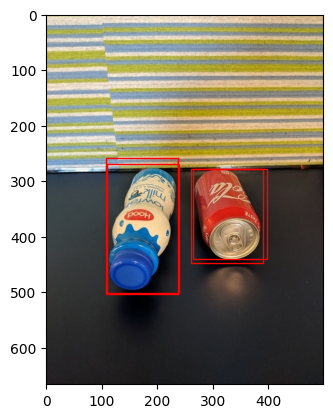

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.figure()
fig, ax = plt.subplots()
ax.imshow(img.mul(255).permute(1, 2, 0).byte().numpy())
for x in prediction[0]['boxes'].cpu().numpy():
  print(x)
  rect = patches.Rectangle((x[0], x[1]), x[2]-x[0], x[3]-x[1], linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)

plt.show()

In [ ]:
# pick one image from the test set
img, _ = dataset_test[6]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

[ 56.423523 282.7899   432.77692  441.87103 ]


<Figure size 640x480 with 0 Axes>

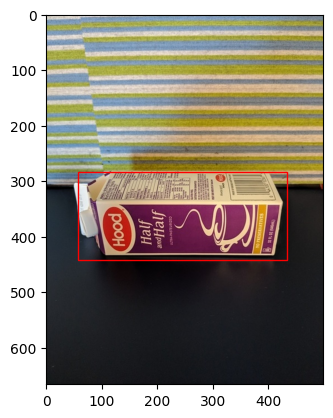

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.figure()
fig, ax = plt.subplots()
ax.imshow(img.mul(255).permute(1, 2, 0).byte().numpy())
for x in prediction[0]['boxes'].cpu().numpy():
  print(x)
  rect = patches.Rectangle((x[0], x[1]), x[2]-x[0], x[3]-x[1], linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)

plt.show()